I use the same dataset for GAN in my AOL project. This dataset already passed our preprocessing GAN model and jost copy paste it to this Masked Auto Encoder project. The folder contains 19.696 images with 2556 * 256 resolution all with already 1:1 aspect ratio.

Arieldhipta Tarliman - 2702234636

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from torchinfo import summary
from tqdm import tqdm

In [ ]:
DATA_DIR = './real_sampled'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
IMG_SIZE = 256
MASK_RATIO = 0.75
PATCH_SIZE = 16
NUM_EPOCHS = 100 
LEARNING_RATE = 1e-4 
PATIENCE = 5 

In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

For Early stopping with fast patience because of experimentation purpose.

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, image_files, transform=None):
        self.root_dir = root_dir
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

Read the dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

all_files = [f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
random.shuffle(all_files)

train_files, test_val_files = train_test_split(all_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_val_files, test_size=(10/30), random_state=42)

train_dataset = FaceDataset(DATA_DIR, train_files, transform)
val_dataset = FaceDataset(DATA_DIR, val_files, transform)
test_dataset = FaceDataset(DATA_DIR, test_files, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data split: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test images.")


Data split: 13787 train, 3939 validation, 1970 test images.


Split and transform dataset 

In [ ]:
def create_patch_mask(images, patch_size, mask_ratio):
    B, C, H, W = images.shape
    num_patches_h, num_patches_w = H // patch_size, W // patch_size
    num_patches = num_patches_h * num_patches_w
    num_masked = int(mask_ratio * num_patches)
    patch_indices = torch.randperm(num_patches)
    masked_indices = patch_indices[:num_masked]
    mask = torch.ones(num_patches, device=images.device)
    mask[masked_indices] = 0
    mask = mask.view(1, 1, num_patches_h, num_patches_w)
    mask = mask.repeat_interleave(patch_size, dim=2).repeat_interleave(patch_size, dim=3)
    return images * mask, mask

class MaskedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(256, 512, 3, 2, 1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh(),
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))


In [ ]:
def calculate_psnr(mse, max_pixel_val=1.0):
    """Calculates PSNR from MSE. Images are on [0,1] scale after denormalization."""
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_pixel_val / math.sqrt(mse))

model = MaskedAutoencoder().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
early_stopper = EarlyStopper(patience=PATIENCE)

summary(model, input_size=(1, 3, 256, 256))  

Layer (type:depth-idx)                   Output Shape              Param #
MaskedAutoencoder                        [1, 3, 256, 256]          --
├─Sequential: 1-1                        [1, 512, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─ReLU: 2-2                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 128, 64, 64]          73,856
│    └─ReLU: 2-4                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-5                       [1, 256, 32, 32]          295,168
│    └─ReLU: 2-6                         [1, 256, 32, 32]          --
│    └─Conv2d: 2-7                       [1, 512, 16, 16]          1,180,160
│    └─ReLU: 2-8                         [1, 512, 16, 16]          --
├─Sequential: 1-2                        [1, 3, 256, 256]          --
│    └─ConvTranspose2d: 2-9              [1, 256, 32, 32]          2,097,408
│    └─ReLU: 2-10                        [1, 256, 32, 32]  

To reconstruct masked facial images, I designed a fully convolutional autoencoder for 256x256 pixel inputs. The encoder progressively downsamples the image through four convolutional blocks, halving the spatial dimensions at each step while doubling the feature channels, ultimately compressing the input into a compact 16x16x512 latent representation. A symmetric decoder then mirrors this process, using transposed convolutions to efficiently upsample the feature map back to the original 256x256 resolution. The final Tanh activation layer ensures the reconstructed output is normalized to the same [-1, 1] range as the input data, with the entire model comprising a total of 4.3 million trainable parameters.

For my model's evaluation, I selected two standard and complementary metrics to quantitatively measure the quality of the image reconstruction: Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR). 

Peak Signal-to-Noise Ratio (PSNR): While MSE is excellent for training, its raw values (0.01) aren't very intuitive for judging visual quality. Therefore, I also used PSNR, a classic metric in image processing derived from the MSE. It measures the ratio between the maximum possible pixel value (the "signal") and the reconstruction error (the "noise"), expressed on a logarithmic decibel (dB) scale.

In summary, I use MSE as the engine for training the model and PSNR as the dashboard gauge to clearly interpret the final visual performance.

The lower the MSE the better & the higher the PSNR the better >30 is good.

In [ ]:
print("Starting training...")
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    model.train()
    train_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc="Training")
    
    for images in train_progress_bar:
        images = images.to(DEVICE)
        masked_images, _ = create_patch_mask(images, PATCH_SIZE, MASK_RATIO)
        
        optimizer.zero_grad()
        outputs = model(masked_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        train_progress_bar.set_postfix(batch_loss=f"{loss.item():.6f}")
    
    avg_train_loss = train_loss / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_progress_bar = tqdm(val_loader, desc="Validating")
    
    with torch.no_grad():
        for images in val_progress_bar:
            images = images.to(DEVICE)
            masked_images, _ = create_patch_mask(images, PATCH_SIZE, MASK_RATIO)
            outputs = model(masked_images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)
            
            val_progress_bar.set_postfix(batch_loss=f"{loss.item():.6f}")

    avg_val_loss = val_loss / len(val_dataset)
    val_psnr = calculate_psnr(avg_val_loss, max_pixel_val=4.0)
    
    print(f"Epoch Summary | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val PSNR: {val_psnr:.2f} dB")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_mae_model.pth')
        print(f"    -> Model improved, saving to 'best_mae_model.pth'")

    if early_stopper.early_stop(avg_val_loss):
        print(f"Validation loss has not improved for {PATIENCE} epochs. Stopping early.")
        break

Starting training...

Epoch 1/100


Validating: 100%|██████████| 124/124 [01:02<00:00,  1.99it/s, batch_loss=0.074989]


Epoch Summary | Train Loss: 0.123953 | Val Loss: 0.087916 | Val PSNR: 22.60 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 2/100


Validating: 100%|██████████| 124/124 [00:25<00:00,  4.93it/s, batch_loss=0.073756]


Epoch Summary | Train Loss: 0.079336 | Val Loss: 0.075031 | Val PSNR: 23.29 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 3/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.45it/s, batch_loss=0.069600]


Epoch Summary | Train Loss: 0.073221 | Val Loss: 0.071364 | Val PSNR: 23.51 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 4/100


Validating: 100%|██████████| 124/124 [00:24<00:00,  5.15it/s, batch_loss=0.054846]


Epoch Summary | Train Loss: 0.071275 | Val Loss: 0.068930 | Val PSNR: 23.66 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 5/100


Validating: 100%|██████████| 124/124 [00:27<00:00,  4.44it/s, batch_loss=0.059061]


Epoch Summary | Train Loss: 0.069636 | Val Loss: 0.067298 | Val PSNR: 23.76 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 6/100


Validating: 100%|██████████| 124/124 [00:25<00:00,  4.79it/s, batch_loss=0.064636]


Epoch Summary | Train Loss: 0.068008 | Val Loss: 0.066464 | Val PSNR: 23.82 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 7/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.51it/s, batch_loss=0.093728]


Epoch Summary | Train Loss: 0.066991 | Val Loss: 0.066514 | Val PSNR: 23.81 dB

Epoch 8/100


Validating: 100%|██████████| 124/124 [00:24<00:00,  5.05it/s, batch_loss=0.046432]


Epoch Summary | Train Loss: 0.065943 | Val Loss: 0.064212 | Val PSNR: 23.97 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 9/100


Validating: 100%|██████████| 124/124 [00:26<00:00,  4.73it/s, batch_loss=0.066085]


Epoch Summary | Train Loss: 0.064015 | Val Loss: 0.063801 | Val PSNR: 23.99 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 10/100


Validating: 100%|██████████| 124/124 [00:25<00:00,  4.86it/s, batch_loss=0.066721]


Epoch Summary | Train Loss: 0.063196 | Val Loss: 0.062130 | Val PSNR: 24.11 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 11/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.43it/s, batch_loss=0.068703]


Epoch Summary | Train Loss: 0.062172 | Val Loss: 0.061415 | Val PSNR: 24.16 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 12/100


Validating: 100%|██████████| 124/124 [00:24<00:00,  4.98it/s, batch_loss=0.056356]


Epoch Summary | Train Loss: 0.062074 | Val Loss: 0.060997 | Val PSNR: 24.19 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 13/100


Validating: 100%|██████████| 124/124 [00:24<00:00,  5.07it/s, batch_loss=0.055797]


Epoch Summary | Train Loss: 0.061192 | Val Loss: 0.061131 | Val PSNR: 24.18 dB

Epoch 14/100


Validating: 100%|██████████| 124/124 [00:20<00:00,  6.07it/s, batch_loss=0.066887]


Epoch Summary | Train Loss: 0.060198 | Val Loss: 0.060900 | Val PSNR: 24.20 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 15/100


Validating: 100%|██████████| 124/124 [00:23<00:00,  5.30it/s, batch_loss=0.048626]


Epoch Summary | Train Loss: 0.060330 | Val Loss: 0.059467 | Val PSNR: 24.30 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 16/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.51it/s, batch_loss=0.060574]


Epoch Summary | Train Loss: 0.059965 | Val Loss: 0.060330 | Val PSNR: 24.24 dB

Epoch 17/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.59it/s, batch_loss=0.063443]


Epoch Summary | Train Loss: 0.059679 | Val Loss: 0.059458 | Val PSNR: 24.30 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 18/100


Validating: 100%|██████████| 124/124 [00:20<00:00,  5.98it/s, batch_loss=0.048751]


Epoch Summary | Train Loss: 0.059565 | Val Loss: 0.059677 | Val PSNR: 24.28 dB

Epoch 19/100


Validating: 100%|██████████| 124/124 [00:21<00:00,  5.73it/s, batch_loss=0.051932]


Epoch Summary | Train Loss: 0.059311 | Val Loss: 0.059199 | Val PSNR: 24.32 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 20/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.52it/s, batch_loss=0.054363]


Epoch Summary | Train Loss: 0.058979 | Val Loss: 0.058212 | Val PSNR: 24.39 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 21/100


Validating: 100%|██████████| 124/124 [00:23<00:00,  5.36it/s, batch_loss=0.049412]


Epoch Summary | Train Loss: 0.058191 | Val Loss: 0.057827 | Val PSNR: 24.42 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 22/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.60it/s, batch_loss=0.050514]


Epoch Summary | Train Loss: 0.058739 | Val Loss: 0.057945 | Val PSNR: 24.41 dB

Epoch 23/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.52it/s, batch_loss=0.057130]


Epoch Summary | Train Loss: 0.058050 | Val Loss: 0.057866 | Val PSNR: 24.42 dB

Epoch 24/100


Validating: 100%|██████████| 124/124 [00:23<00:00,  5.39it/s, batch_loss=0.048933]


Epoch Summary | Train Loss: 0.057997 | Val Loss: 0.057366 | Val PSNR: 24.45 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 25/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.42it/s, batch_loss=0.064299]


Epoch Summary | Train Loss: 0.058121 | Val Loss: 0.057837 | Val PSNR: 24.42 dB

Epoch 26/100


Validating: 100%|██████████| 124/124 [00:23<00:00,  5.25it/s, batch_loss=0.060465]


Epoch Summary | Train Loss: 0.057256 | Val Loss: 0.056814 | Val PSNR: 24.50 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 27/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.49it/s, batch_loss=0.051333]


Epoch Summary | Train Loss: 0.057707 | Val Loss: 0.057052 | Val PSNR: 24.48 dB

Epoch 28/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.48it/s, batch_loss=0.049265]


Epoch Summary | Train Loss: 0.056863 | Val Loss: 0.057255 | Val PSNR: 24.46 dB

Epoch 29/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.47it/s, batch_loss=0.051002]


Epoch Summary | Train Loss: 0.057253 | Val Loss: 0.056178 | Val PSNR: 24.55 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 30/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.50it/s, batch_loss=0.052666]


Epoch Summary | Train Loss: 0.056625 | Val Loss: 0.057389 | Val PSNR: 24.45 dB

Epoch 31/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.49it/s, batch_loss=0.051686]


Epoch Summary | Train Loss: 0.056248 | Val Loss: 0.055647 | Val PSNR: 24.59 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 32/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.51it/s, batch_loss=0.045399]


Epoch Summary | Train Loss: 0.056553 | Val Loss: 0.055784 | Val PSNR: 24.58 dB

Epoch 33/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.48it/s, batch_loss=0.049160]


Epoch Summary | Train Loss: 0.056341 | Val Loss: 0.056252 | Val PSNR: 24.54 dB

Epoch 34/100


Validating: 100%|██████████| 124/124 [00:22<00:00,  5.50it/s, batch_loss=0.048513]


Epoch Summary | Train Loss: 0.056722 | Val Loss: 0.055860 | Val PSNR: 24.57 dB

Epoch 35/100


Validating: 100%|██████████| 124/124 [00:23<00:00,  5.37it/s, batch_loss=0.054362]


Epoch Summary | Train Loss: 0.056279 | Val Loss: 0.055706 | Val PSNR: 24.58 dB

Epoch 36/100


Validating: 100%|██████████| 124/124 [00:21<00:00,  5.65it/s, batch_loss=0.053808]


Epoch Summary | Train Loss: 0.055897 | Val Loss: 0.054814 | Val PSNR: 24.65 dB
    -> Model improved, saving to 'best_mae_model.pth'

Epoch 37/100


Training:   5%|▍         | 20/431 [00:06<02:13,  3.07it/s, batch_loss=0.058775]


KeyboardInterrupt: 

Well lets just use a model that has been trained for 100minutes just for experimentatinal purposes. Yes the val PSNR still not good and the model loss is great but lets just see the result.


--- Training finished. Loading best model and running on test set. ---


Testing: 100%|██████████| 62/62 [00:10<00:00,  5.94it/s]



--- Final Test Results ---
Test MSE: 0.054992
Test PSNR: 24.64 dB
--------------------------

Visualizing final results on the test set...


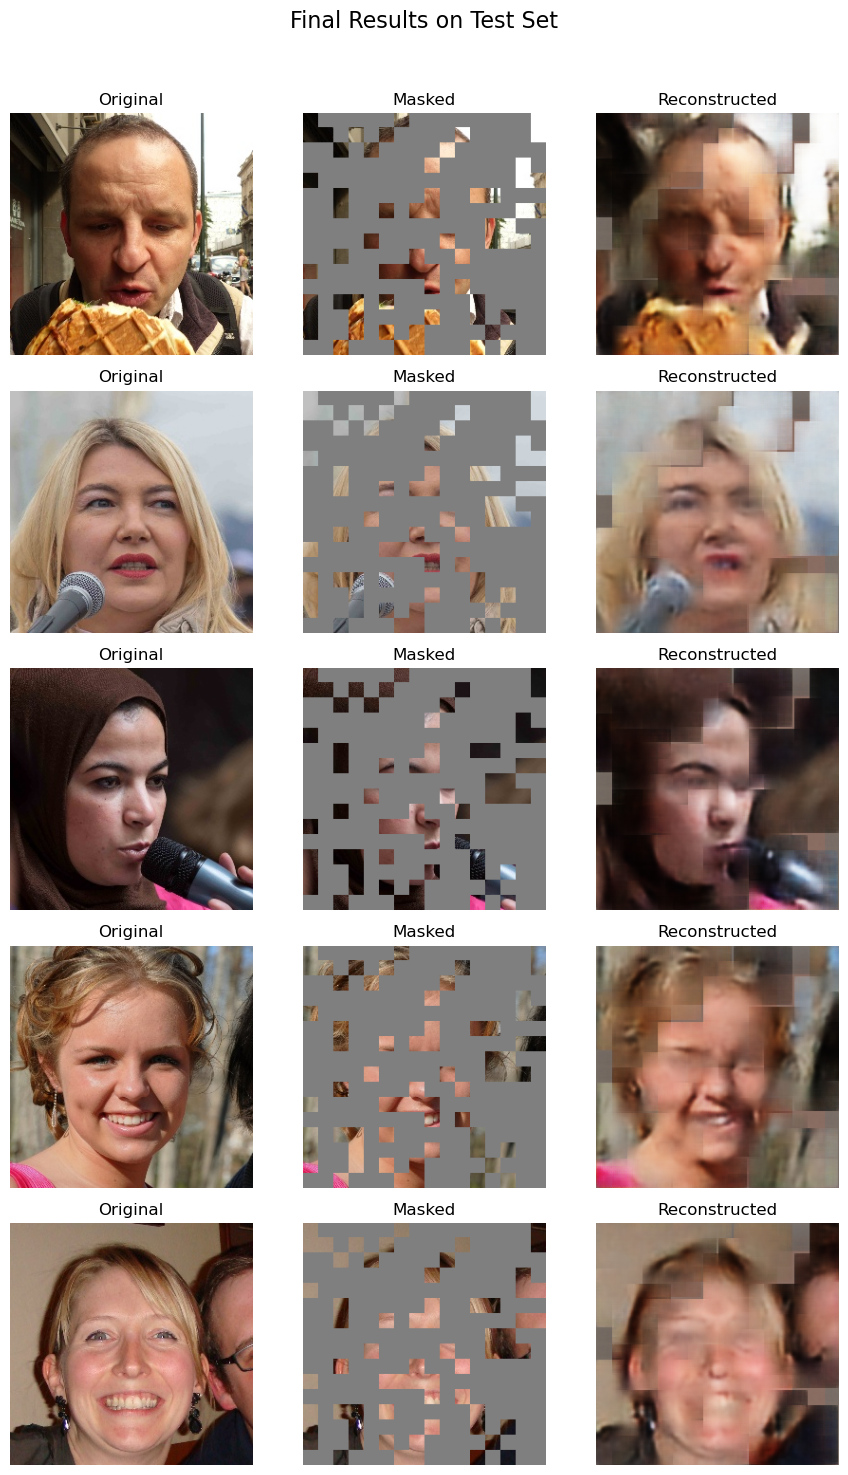

Final results saved to 'mae_final_test_results.png'


In [ ]:
print("\n--- Training finished. Loading best model and running on test set. ---")
model.load_state_dict(torch.load('best_mae_model.pth'))
model.eval()

test_loss = 0.0

test_progress_bar = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images in test_progress_bar:
        images = images.to(DEVICE)
        masked_images, _ = create_patch_mask(images, PATCH_SIZE, MASK_RATIO)
        outputs = model(masked_images)
        loss = criterion(outputs, images)
        test_loss += loss.item() * images.size(0)

avg_test_loss = test_loss / len(test_dataset)
test_psnr = calculate_psnr(avg_test_loss, max_pixel_val=4.0)

print("\n--- Final Test Results ---")
print(f"Test MSE: {avg_test_loss:.6f}")
print(f"Test PSNR: {test_psnr:.2f} dB")
print("--------------------------")

def visualize_results(model, dataloader, device):
    
    model.eval()
    original_images = next(iter(dataloader)).to(device)[:5]
    masked_images, _ = create_patch_mask(original_images, PATCH_SIZE, MASK_RATIO)
    with torch.no_grad():
        reconstructed_images = model(masked_images)
    
    inv_normalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
    
    fig, axes = plt.subplots(5, 3, figsize=(9, 15))
    fig.suptitle('Final Results on Test Set', fontsize=16)
    for i in range(5):
        axes[i, 0].imshow(inv_normalize(original_images[i]).cpu().permute(1, 2, 0))
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(inv_normalize(masked_images[i]).cpu().permute(1, 2, 0))
        axes[i, 1].set_title("Masked")
        axes[i, 1].axis('off')
        axes[i, 2].imshow(inv_normalize(reconstructed_images[i]).cpu().permute(1, 2, 0))
        axes[i, 2].set_title("Reconstructed")
        axes[i, 2].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('mae_final_test_results.png')
    plt.show()

print("\nVisualizing final results on the test set...")
visualize_results(model, test_loader, DEVICE)
print("Final results saved to 'mae_final_test_results.png'")

I actually kind of suprise that the model can genrate images nearly perfect its just moerr pixelated, neeed more training and also more detailing stuff but becauswe of my computational power it can't go more than teh parameter i use. The model still struggle to generate images that are a psecific detailed one like the eyes of teh hunma in that pictures, need more adjustment, but with 75% masked its already great for experimentatinal purposes